## Import Library

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset

In [2]:
dataset_train_path = "data/train"
dataset_test_path = "data/test"
dataset_validation_path = "data/validation"

img_width = 180
img_height = 180
batch_size = 32

data_train = tf.keras.utils.image_dataset_from_directory(
    dataset_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    #validation_split=0.2,  # 20% dari train akan jadi validation
    #subset="training",
    #seed=42  # Pastikan ada seed agar pembagian tetap konsisten
)

data_val = tf.keras.utils.image_dataset_from_directory(
    dataset_validation_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    #validation_split=0.2,  # Sama dengan data_train
    #subset="validation",
    #seed=42
)

data_test = tf.keras.utils.image_dataset_from_directory(
    dataset_test_path,
    image_size=(img_height, img_width),
    shuffle=False,  # Jangan acak agar prediksi sesuai dengan urutan label
    batch_size=batch_size
)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


In [3]:
data_cat = data_train.class_names
print(data_cat)

['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


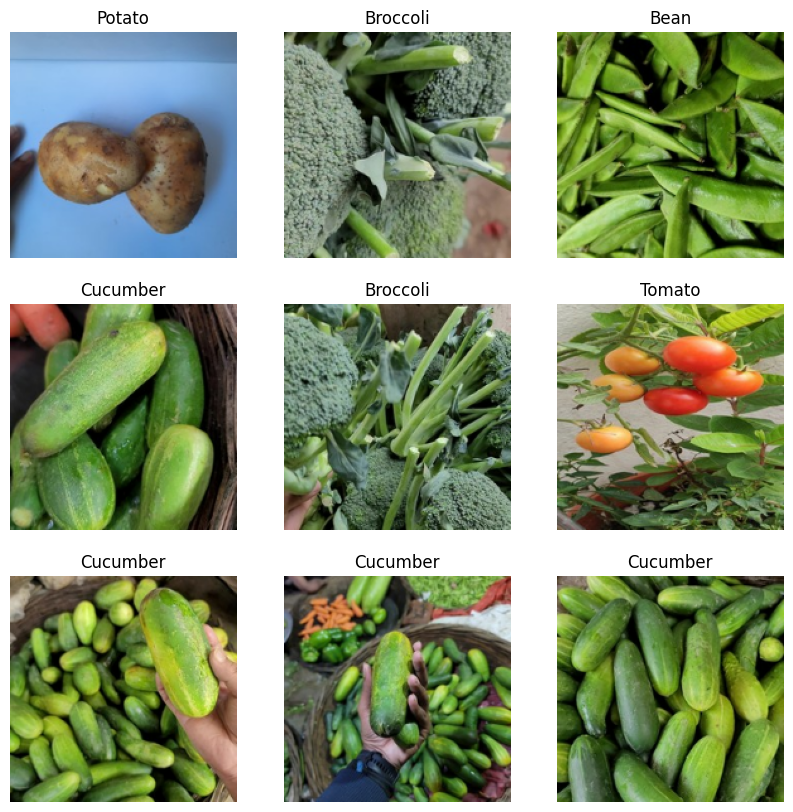

In [ ]:
plt.figure(figsize=(10,10))
for image, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')



**Data augmentation**

In [5]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),  # Membalik gambar secara horizontal
    layers.RandomRotation(0.2),  # Rotasi acak hingga 20%
    layers.RandomZoom(0.2),  # Zoom in/out hingga 20%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Translasi gambar
    layers.RandomContrast(0.2),  # Mengubah kontras gambar hingga 20%
    layers.RandomBrightness(0.2),  # Mengubah kecerahan gambar hingga 20%
    layers.RandomCrop(height=180, width=180),  # Crop acak (sesuaikan dengan ukuran gambar)
])

data_train = data_train.map(lambda x, y: (data_augmentation(x, training=True), y))

## Model

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
data_train = data_train.prefetch(buffer_size=AUTOTUNE)
data_val = data_val.prefetch(buffer_size=AUTOTUNE)
data_test = data_test.prefetch(buffer_size=AUTOTUNE)

In [7]:
from tensorflow.keras.models import Sequential

**Convolutional Neural Network (CNN)**

In [ ]:
model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(data_cat), activation='softmax')
])

In [9]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Train Model**

In [10]:

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

**กำหนด callbacks 2 ตัวที่ช่วยควบคุมการฝึก (training) ของโมเดลใน TensorFlow/Keras เพื่อลด overfitting และปรับ learning rate**

In [11]:

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

callbacks = [early_stop, reduce_lr]

In [12]:
epochs_size = 15
history = model.fit(data_train, validation_data=data_val, epochs=epochs_size, callbacks=callbacks)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 397ms/step - accuracy: 0.1802 - loss: 3.0269 - val_accuracy: 0.2947 - val_loss: 2.2573 - learning_rate: 0.0010
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 185s 393ms/step - accuracy: 0.3479 - loss: 1.9404 - val_accuracy: 0.4333 - val_loss: 1.5614 - learning_rate: 0.0010
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 184s 391ms/step - accuracy: 0.4521 - loss: 1.5692 - val_accuracy: 0.2863 - val_loss: 4.7607 - learning_rate: 0.0010
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 244s 520ms/step - accuracy: 0.5174 - loss: 1.3989 - val_accuracy: 0.4290 - val_loss: 2.1053 - learning_rate: 0.0010
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 172s 367ms/step - accuracy: 0.6016 - loss: 1.1288 - val_accuracy: 0.7010 - val_loss: 0.9013 - learning_rate: 5.0000e-04
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 178s 380ms/step - accuracy: 0.6413 - loss: 1.0119 - val_accuracy: 0.6727 - val_loss: 1.1252 - learning_rate: 5.0000e-04
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 182s 388ms/step 

**plot loss accuracy**

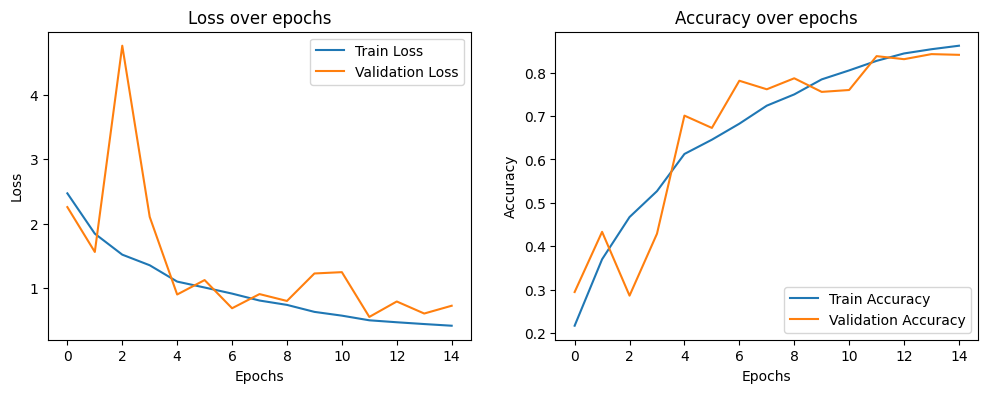

In [13]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(12, 4))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over epochs')
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    
    plt.show()

plot_loss_accuracy(history)

**ประเมินค่าความสูญเสีย (Loss) และค่าความแม่นยำ (Accuracy)**

In [14]:
model.evaluate(data_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.8233 - loss: 0.5943


[0.5803630948066711, 0.831333339214325]

In [15]:
model.evaluate(data_train)

469/469 ━━━━━━━━━━━━━━━━━━━━ 96s 204ms/step - accuracy: 0.9075 - loss: 0.2929


[0.2949129343032837, 0.9050666689872742]

**Save model**

In [16]:
model.save('my_model.h5')


In [17]:
import tensorflow as tf

# โหลดโมเดลจากไฟล์ที่บันทึกไว้
model = tf.keras.models.load_model('my_model.h5')  # หรือ 'my_model' หากใช้ SavedModel format

# แสดงโครงสร้างโมเดล
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,991,025 (15.22 MB)

 Trainable params: 3,990,799 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 2 (12.00 B)

In [18]:
# ทดสอบโมเดลกับชุดข้อมูลทดสอบ
loss, accuracy = model.evaluate(data_test)
print(f'Test Accuracy: {accuracy:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8233 - loss: 0.5943
Test Accuracy: 0.8313


In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# ตั้งค่าขนาดภาพ
img_width = 180
img_height = 180
batch_size = 32

# โหลด dataset
dataset_train_path = "data/train"

data_train = tf.keras.utils.image_dataset_from_directory(
    dataset_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=batch_size,
)

# ดึงชื่อคลาสจาก dataset
class_names = data_train.class_names  # ✅ แก้ไข: บันทึก class_names แยกออกมา
print("Class Names:", class_names)  # ✅ ตรวจสอบชื่อคลาส

# โหลดโมเดล
model = tf.keras.models.load_model('my_model.h5')

def predict_image(img_path, model, class_names):
    # โหลดและเตรียมภาพ
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img) / 255.0  # Normalize [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # เปลี่ยนเป็น batch (1, 180, 180, 3)

    # ทำการพยากรณ์
    predictions = model.predict(img_array)
    print("--> Predictions:", predictions)  # ✅ Debug: พิมพ์ค่าพยากรณ์ออกมา

    predicted_class = np.argmax(predictions)  # ดึง index ของ class ที่มีค่ามากที่สุด
    print(f'Predicted Class: {class_names[predicted_class]}')

# ทดสอบการทำนายภาพ
test_image = 'data/test/Tomato/1001.jpg'
predict_image(test_image, model, class_names)


Found 15000 files belonging to 15 classes.


Class Names: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
--> Predictions: [[1.9992553e-11 4.4109612e-07 1.0707994e-12 9.5433806e-13 2.5352642e-09
  5.1015195e-07 7.3331792e-12 3.9218637e-10 6.8854558e-04 3.3191790e-07
  2.6041107e-15 2.7393195e-05 9.9928182e-01 2.2942575e-14 9.5890789e-07]]
Predicted Class: Pumpkin


In [23]:
import os

# ระบุโฟลเดอร์ที่มีภาพทดสอบ
test_folder = 'data/test/Bean'

# ดึงรายชื่อไฟล์ทั้งหมดในโฟลเดอร์
test_images = [os.path.join(test_folder, img) for img in os.listdir(test_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]

# วนลูปเพื่อทำนายแต่ละภาพ
for test_image in test_images:
    print(f"\n🔍 Predicting: {test_image}")
    predict_image(test_image, model, class_names)



🔍 Predicting: data/test/Bean\0001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
--> Predictions: [[1.0358868e-11 2.6200780e-07 6.2558839e-13 6.7184360e-13 2.3663820e-09
  4.8012396e-07 3.3191952e-12 1.7646702e-10 5.6022516e-04 2.0924813e-07
  1.3321056e-15 1.9272780e-05 9.9941885e-01 1.2483512e-14 6.9540300e-07]]
Predicted Class: Pumpkin

🔍 Predicting: data/test/Bean\0002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
--> Predictions: [[1.09600532e-11 2.58759911e-07 6.19017804e-13 7.11227735e-13
  2.42027420e-09 3.85970537e-07 3.73911188e-12 1.87950003e-10
  6.00601546e-04 2.11977806e-07 1.30775704e-15 2.44299517e-05
  9.99373496e-01 1.38948504e-14 7.06288290e-07]]
Predicted Class: Pumpkin

🔍 Predicting: data/test/Bean\0003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
--> Predictions: [[2.0049875e-11 4.1190080e-07 1.0459945e-12 1.0015275e-12 2.6680966e-09
  5.0418743e-07 7.1935383e-12 3.6448372e-10 6.6038658e-04 3.1958044e-07
  2.5026965e-15 2.8619752e-05 9.9930871e-01 2.2059037e-14 9.4739215e-07